In [152]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error

from scipy.stats import boxcox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [153]:
df = pd.read_csv('data/eps_quarter.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [155]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [156]:
df.tail()

,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


## 📌 Plot the Time Series Data

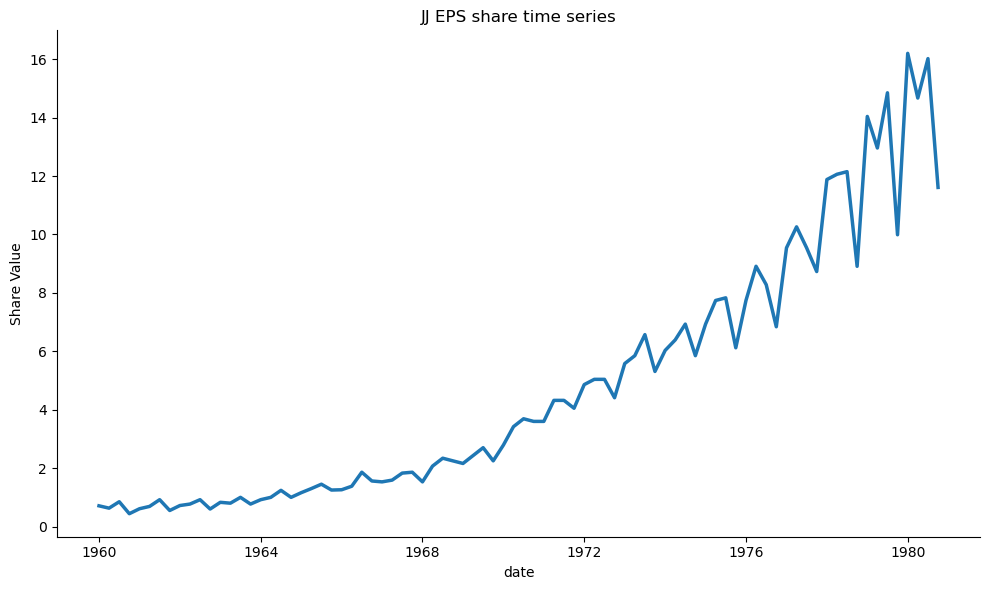

In [157]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'])
plt.title('JJ EPS share time series')

plt.xlabel('date')
plt.ylabel('Share Value')

plt.tight_layout()
plt.show()

In [159]:
# # ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series)

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

# Box Cox Transformation - Reduce Variance

In [161]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

def apply_boxcox(series, plot=True):
    """
    Applies Box-Cox transformation to the input series.

    Parameters:
    - series (pd.Series): The time series data.
    - plot (bool): If True, plots the histogram of transformed data.

    Returns:
    - transformed_series (pd.Series): Box-Cox transformed data with the same index as input.
    - lambda_value (float): Optimal lambda value for the transformation.
    """

    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a Pandas Series.")

    # Handle zero or negative values by shifting data if needed
    shift = 0
    if (series <= 0).any():
        shift = np.abs(series.min()) + 1e-6
        print(f"Non-positive values detected! Shifting data by {shift:.6f}")
        series = series + shift

    # Apply Box-Cox transformation
    transformed_data, lambda_value = stats.boxcox(series.values)

    # Convert back to pandas Series (retain original index)
    transformed_series = pd.Series(transformed_data, index=series.index)

 

    return transformed_series, lambda_value



In [162]:
# Function to perform inverse Box-Cox transformation
def inverse_boxcox(y, lam):
    return np.power(y * lam + 1, 1 / lam) if lam != 0 else np.exp(y)

In [163]:
# Apply Box-Cox transformation
df_boxcox, lambda_value = apply_boxcox(df['data'])

# Print the optimal lambda value
print(f"Optimal λ (lambda): {lambda_value:.4f}")

Optimal λ (lambda): 0.0507


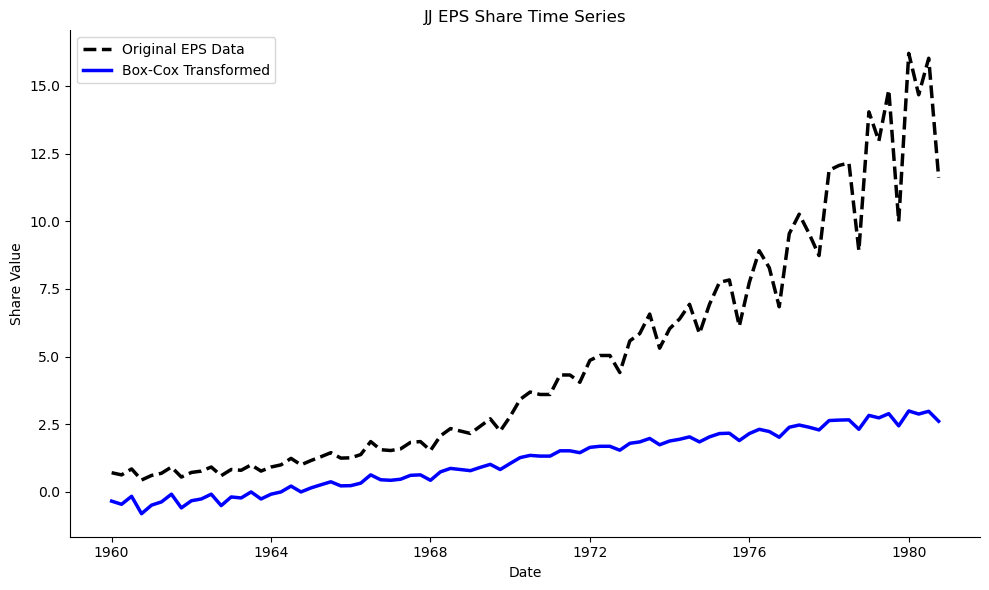

In [164]:
plt.figure(figsize=(10, 6))

# Plot original series
plt.plot(df, label="Original EPS Data", color="black", linestyle="dashed")

# Plot Box-Cox transformed series
plt.plot(df_boxcox, label="Box-Cox Transformed", color="blue")

# Title and labels
plt.title('JJ EPS Share Time Series')
plt.xlabel('Date')
plt.ylabel('Share Value')

# Add legend
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

In [165]:
adf_test(df_boxcox)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -0.302498
               p-value  0.925150
           # Lags Used  4.000000
Number of Observations 79.000000
   Critical Value (1%) -3.515977
   Critical Value (5%) -2.898886
  Critical Value (10%) -2.586694

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.92515 > 0.05)


### Apply differencing

In [166]:
# create a differenced series
def trend_difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [167]:
# Apply differencing on just one column, assuming 'inflation' is the column of interest
eps_diff = trend_difference(df_boxcox, interval=1)

### Adfuller test to check stationarity of differenced series

In [168]:
adf_test(eps_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -4.381474
               p-value  0.000320
           # Lags Used  5.000000
Number of Observations 77.000000
   Critical Value (1%) -3.518281
   Critical Value (5%) -2.899878
  Critical Value (10%) -2.587223

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00032 ≤ 0.05)


In [169]:
# adf_test(eps_diff2)

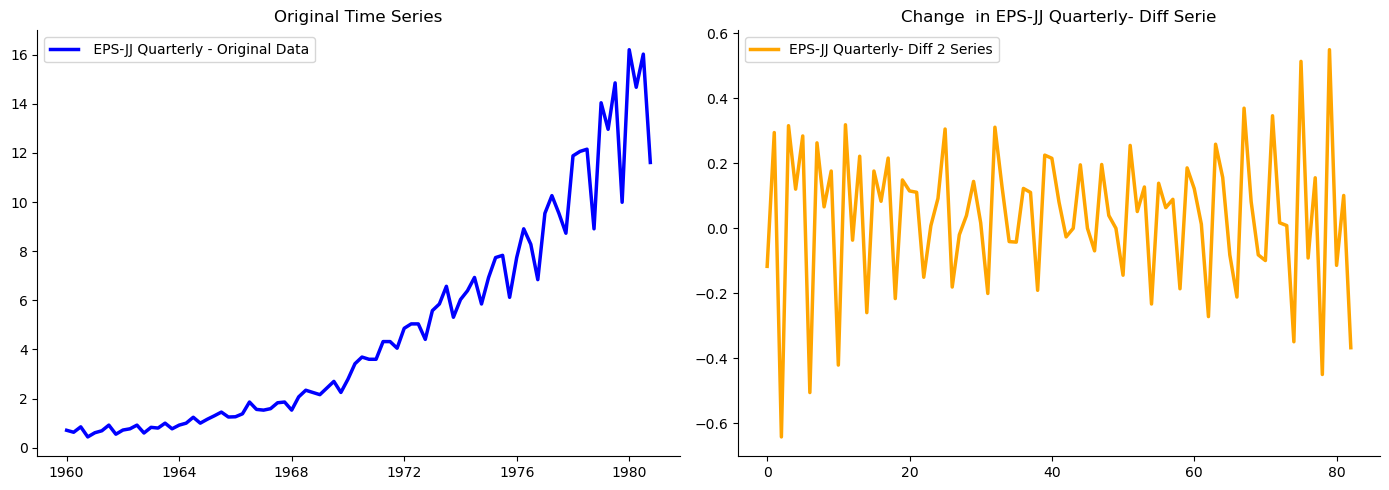

In [170]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label=' EPS-JJ Quarterly - Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(eps_diff, label="EPS-JJ Quarterly- Diff 2 Series", color='orange')
axes[1].set_title('Change  in EPS-JJ Quarterly- Diff Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

## Train ARIMA Model

In [173]:
# Splitting data_boxcox
train = df[:80]
test = df[80:]

In [174]:
# Splitting data_boxcox
train_data_boxcox = df_boxcox[:80]
test_data_boxcox = df_boxcox[80:]

In [201]:
model = ARIMA(train_data_boxcox, order=(3,1,2))
model_fit = model.fit()
residuals = model_fit.resid

In [202]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  51.882
Date:                Thu, 27 Feb 2025   AIC                            -91.765
Time:                        17:32:39   BIC                            -77.548
Sample:                             0   HQIC                           -86.069
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0290      0.073    -14.002      0.000      -1.173      -0.885
ar.L2         -0.9657      0.082    -11.739      0.000      -1.127      -0.804
ar.L3         -0.8590      0.051    -16.965      0.0

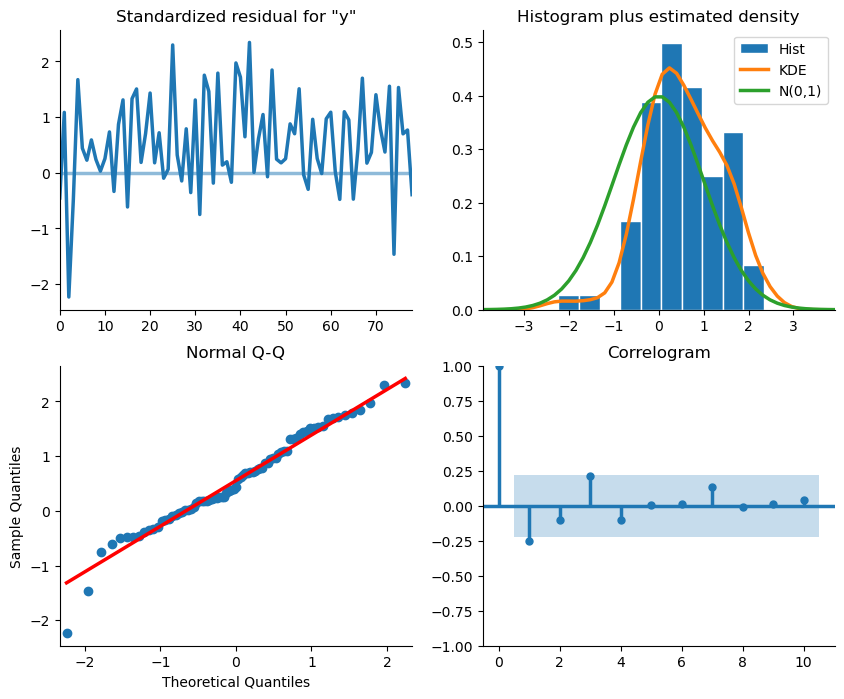

In [203]:
model_fit.plot_diagnostics(figsize=(10, 8));

## 🔹 Evaluate Model

In [204]:
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

# Example: Assuming lambda_value is the lambda used during Box-Cox transformation
lambda_value = 0.0507  # This should be the lambda value from your original Box-Cox transformation

history = [x for x in train_data_boxcox]  # Initial history from training set
predictions = []

# Perform the forecasting
for t in range(len(test_data_boxcox)):
    model = ARIMA(history, order=(3, 1, 3))
    model_fit = model.fit()
    yhat_boxcox = model_fit.forecast()[0]

    # Apply inverse Box-Cox transformation to get the actual predicted value
    yhat = inv_boxcox(yhat_boxcox, lambda_value)

    predictions.append(yhat)

    # Append the Box-Cox transformed value to history
    history.append(test_data_boxcox[t])

    # Print the prediction and actual value (after reversing the Box-Cox transformation for the actual value)
    actual_value = inv_boxcox(test_data_boxcox[t], lambda_value)  # Reverse Box-Cox for actual value
    print(f"Predicted (Box-Cox Reversed)={yhat}, Expected (Original)={actual_value}")

# After all predictions are done, calculate MAE, MSE, RMSE on the original scale:

# Calculate MAE
mae = mean_absolute_error(test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Optionally: R-squared (Coefficient of Determination)
y_true = np.array(test)
y_pred = np.array(predictions)
ss_total = np.sum((y_true - np.mean(y_true))**2)
ss_residual = np.sum((y_true - y_pred)**2)
r2 = 1 - (ss_residual / ss_total)
print(f"R-squared (R²): {r2}")


Predicted (Box-Cox Reversed)=14.857000630540712, Expected (Original)=16.200618595563185
Predicted (Box-Cox Reversed)=13.949163749806178, Expected (Original)=14.670521828254671
Predicted (Box-Cox Reversed)=15.494973058726352, Expected (Original)=16.020606935558504
Predicted (Box-Cox Reversed)=11.05455921961235, Expected (Original)=11.610345504034647
Mean Absolute Error (MAE): 0.7860758353286013
Mean Squared Error (MSE): 0.7268549888855836
Root Mean Squared Error (RMSE): 0.8525579094029823
R-squared (R²): -7.146928942092087


In [205]:
# Check lengths
print(f"Length of test data: {len(test)}")
print(f"Length of predictions: {len(predictions)}")

Length of test data: 4
Length of predictions: 4


In [206]:
test

,data
date,
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


In [207]:
predictions

[14.857000630540712, 13.949163749806178, 15.494973058726352, 11.05455921961235]

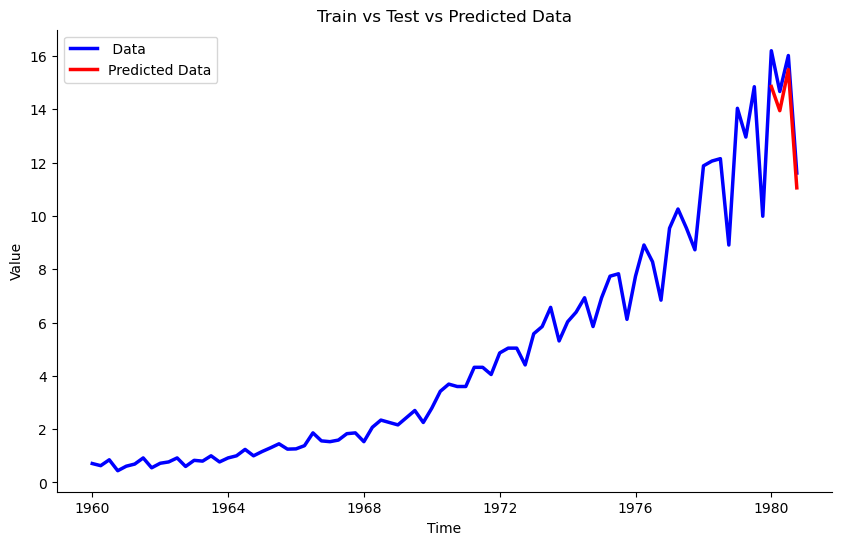

In [208]:
# Create a pandas Series for the predictions with the test data index
predicted_series = pd.Series(predictions, index=test.index)

# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Plot the original training data (train data should be extended for proper display)
plt.plot(df.index, df, color='blue', label=' Data', linestyle='-')

plt.plot(predicted_series.index, predicted_series, color='red', label='Predicted Data', linestyle='-')


# Add labels and title
plt.title('Train vs Test vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()
